In [1]:
import torch
from torch.nn.functional import softmax
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tensor = torch.randn((5, 5),requires_grad=True)
tensor

tensor([[-1.2881,  0.9183, -0.3756,  1.8380,  1.0841],
        [ 0.0169,  0.3672, -0.8594,  0.6141,  1.2651],
        [ 0.4820, -1.8450, -0.9009,  0.3096, -0.6025],
        [ 0.6718,  0.6962,  0.0117,  2.7302,  0.5911],
        [ 1.5603,  0.9307, -0.3981, -0.7517,  0.6009]], requires_grad=True)

In [3]:
def spatial_softmax2d(tensor):
    p = torch.reshape(softmax(torch.reshape(tensor, (-1,)), dim=0), tensor.shape)
    grid_y, grid_x = torch.meshgrid(torch.arange(0, tensor.shape[0]), torch.arange(0, tensor.shape[1]))
    x = torch.sum(grid_x.float() * p)
    y = torch.sum(grid_y.float() * p)
    return p, x, y

p, x, y = spatial_softmax2d(tensor)
p, x, y

(tensor([[0.0048, 0.0436, 0.0120, 0.1094, 0.0515],
         [0.0177, 0.0251, 0.0074, 0.0322, 0.0617],
         [0.0282, 0.0028, 0.0071, 0.0237, 0.0095],
         [0.0341, 0.0349, 0.0176, 0.2669, 0.0314],
         [0.0828, 0.0441, 0.0117, 0.0082, 0.0317]], grad_fn=<ViewBackward>),
 tensor(2.3263, grad_fn=<SumBackward0>),
 tensor(2.1558, grad_fn=<SumBackward0>))

In [4]:
# notice that you need prob dist with dim + 1 to express coordinates 0..dim.
target_x, target_y = torch.rand(2) * (torch.tensor(tensor.shape, dtype=torch.float) - 1)
target_x, target_y

(tensor(1.0122), tensor(2.9429))

In [5]:
# 2x2 matrix that produces required expected values
target = torch.zeros(tensor.shape)
target[torch.floor(target_y).long(), torch.floor(target_x).long()] = (torch.ceil(target_y) - target_y) * (torch.ceil(target_x) - target_x)
target[torch.ceil(target_y).long(), torch.floor(target_x).long()] = (target_y - torch.floor(target_y)) * (torch.ceil(target_x) - target_x)
target[torch.floor(target_y).long(), torch.ceil(target_x).long()] = (torch.ceil(target_y) - target_y) * (target_x - torch.floor(target_x))
target[torch.ceil(target_y).long(), torch.ceil(target_x).long()] = (target_y - torch.floor(target_y)) * (target_x - torch.floor(target_x))
target, torch.sum(target)

(tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 5.6414e-02, 6.9557e-04, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 9.3141e-01, 1.1484e-02, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]]),
 tensor(1.))

In [6]:
# verify that expected values match
grid_y, grid_x = torch.meshgrid(torch.arange(0, target.shape[0]), torch.arange(0, target.shape[1]))
ev_target_x = torch.sum(grid_x.float() * target)
ev_target_y = torch.sum(grid_y.float() * target)
ev_target_x, ev_target_y

(tensor(1.0122), tensor(2.9429))

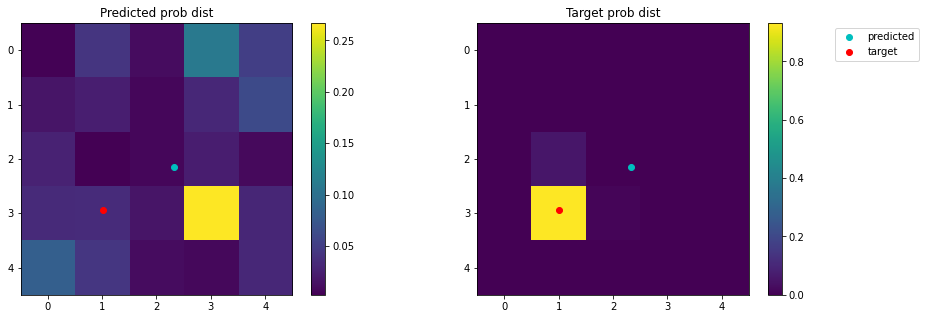

In [7]:
def plot_figure(p, predictions, target, target_x, target_y):
    xs = [x.detach().numpy() for (x, y) in predictions]
    ys = [y.detach().numpy() for (x, y) in predictions]

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(p.detach().numpy(), cmap='viridis', extent=(-0.5, p.shape[1] - 0.5, p.shape[0] - 0.5, -0.5))
    plt.colorbar()
    plt.plot(xs, ys, 'co')
    plt.plot(target_x.detach().numpy(), target_y.detach().numpy(), 'ro')
    plt.title("Predicted prob dist")

    plt.subplot(1, 2, 2)
    plt.imshow(target.detach().numpy(), cmap='viridis', extent=(-0.5, p.shape[1] - 0.5, p.shape[0] - 0.5, -0.5))
    plt.colorbar()
    plt.plot(xs, ys, 'co')
    plt.plot(target_x.detach().numpy(), target_y.detach().numpy(), 'ro')
    plt.title("Target prob dist")
    plt.legend(['predicted', 'target'], loc='upper left', bbox_to_anchor=(1.3, 1))
    plt.show()
    
plot_figure(p, [(x, y)], target, target_x, target_y)

In [8]:
predictions = []

# Run this multiple times with Ctrl+Enter
To test the negative learning, set negative=True in gradient_step() call.

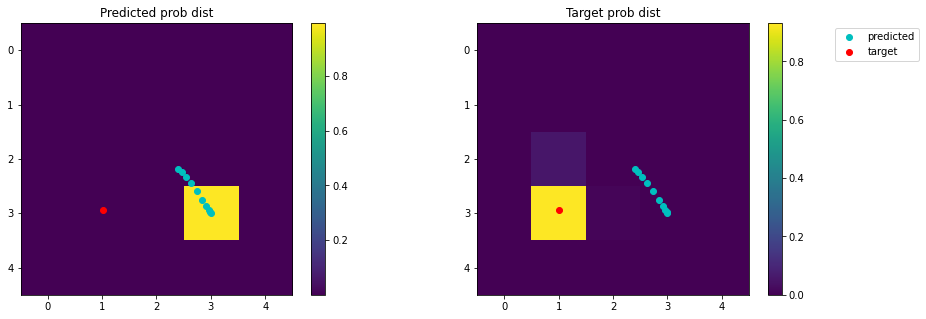

tensor(-15.3382, grad_fn=<NegBackward>)

In [9]:
def gradient_step(tensor, p, target, lr=1.0, negative=False):
    loss = -torch.sum(target * torch.log(p))
    if negative:
        loss = -loss
    loss.backward()
    with torch.no_grad():
        tensor -= lr * tensor.grad
        tensor.grad.zero_()
    return loss

for _ in range(10):
    loss = gradient_step(tensor, p, target, negative=True)
    p, x, y = spatial_softmax2d(tensor)
    predictions.append((x, y))
plot_figure(p, predictions, target, target_x, target_y)
loss

In [10]:
tensor

tensor([[-1.2658,  1.1379, -0.3194,  2.4912,  1.3479],
        [ 0.1012,  0.4887, -0.8250,  0.7721,  1.5890],
        [ 0.6192, -2.3980, -0.8749,  0.4240, -0.5579],
        [ 0.8398, -8.5633, -0.0216,  9.0639,  0.7452],
        [ 2.0194,  1.1532, -0.3431, -0.7133,  0.7567]], requires_grad=True)